# Notebook for comparing different datasets
Here we compare datasets from our experiment with data obtained from other open sources
# Table of contents
1. Load datasets
2. Concatenate Dataframes
3. Run GridSearch
4. Plot results
5. Create table of ML experiments


In [1]:
import os
import re
import configparser

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


from source.processes import Shuffler
from source.datamodels.datamodels import BootstrapDatasetsComparisonResults
from source.datamodels import iterators
from source.preprocessing import splitter
from source.utils import get_project_root

In [2]:
root = get_project_root()
config = configparser.ConfigParser()
config.read(os.path.join(root, "userconfig.ini"))

own_data_path = config['Path']['own_data_path']
third_party_data_path = config['Path']['third_party_data_path']
Cesar1_path = config['Path']['Cesar1_path']

images_path = config['Path']['images_path']
public_images_path = config['Path']['public_images_path']

tables_path = config['Path']['tables_path']
public_tables_path = config['Path']['public_tables_path']

bootstrap_jsons_path = config['Path']['bootstrap_jsons_path']
single_jsons_path = config['Path']['single_jsons_path']

# 1 Load datasets

## 1.1 Load raw datasets
Load datasets that require to be splitted on chunks

In [3]:
full_dataset_our = pd.read_csv(os.path.join(root, own_data_path, 'bearings.csv'), index_col=0)
full_dataset_our.head()

C:\Users\Ruslan\AppData\Roaming\Python\Python38\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,target,experiment_id,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,hz,w
0,0,1,0,1,0.000000,0.113269,0.149706,-0.110275,-0.186030,0.194450,0.454299,0.0,0.0,0.000006
1,0,1,0,1,0.000333,-0.367713,-0.228832,0.177821,0.285992,0.002226,-0.043930,0.0,0.0,0.000243
2,0,1,0,1,0.000667,0.113269,0.149706,-0.398371,-0.091625,0.002226,0.454299,0.0,0.0,0.000369
3,0,1,0,1,0.001000,-0.175320,-0.228832,-0.110275,0.285992,0.002226,0.255007,0.0,0.0,0.000520
4,0,1,0,1,0.001333,-0.079124,0.055072,-0.110275,0.191588,0.002226,0.255007,0.0,0.0,0.000175


In [5]:
full_dataset_cesar = pd.read_csv(os.path.join(root, third_party_data_path, 'N1 Cesar Ricardo/csv/bearings.csv'))
full_dataset_cesar.head()

,target,a1_y,a2_y,rpm,experiment_id,timestamp
0,1,1.937934,1.954861,200,1,0.000000
1,1,1.937547,1.954629,200,1,0.000025
2,1,1.937166,1.954989,200,1,0.000050
3,1,1.937594,1.955540,200,1,0.000075
4,1,1.938502,1.955792,200,1,0.000100


In [15]:
%%time

stats = iterators.Stats.get_keys()
splitter_processor = splitter.Splitter(use_signal=True, use_specter=True, specter_threshold=500, stats=stats, scaler=StandardScaler)
prepared_data_our = splitter_processor.split_dataset(full_dataset_our, stable_area=[(10, 19)], splits_number=10, signal_data_columns=['a1_y', 'a2_y'])
print(f"features number: {prepared_data_our.shape[1]-2}")
print(f"examples number: {prepared_data_our.shape[0]}")

prepared_data_our.to_csv(os.path.join(root, own_data_path, 'processed_full_signal_specter500_Zscale.csv'), index=None)
prepared_data_our.head()

F:\Anaconda\lib\site-packages\scipy\stats\stats.py:1021: RuntimeWarning: divide by zero encountered in true_divide
  return a.std(axis, ddof=ddof) / a.mean(axis)
F:\Anaconda\lib\site-packages\scipy\stats\stats.py:1021: RuntimeWarning: divide by zero encountered in true_divide
  return a.std(axis, ddof=ddof) / a.mean(axis)


features number: 68
examples number: 1120
Wall time: 5min 34s


,target,group,a1_y_signal_kurtosis,a1_y_signal_std,a1_y_signal_sample_entropy,a1_y_signal_energy,a1_y_signal_iqr,a1_y_signal_hurst,a1_y_signal_higuchi_fd,a1_y_signal_complexity,...,a2_y_specter_complexity,a2_y_specter_mean,a2_y_specter_zero_crossing,a2_y_specter_shannon_entropy,a2_y_specter_activity,a2_y_specter_skew,a2_y_specter_variation,a2_y_specter_crest_factor,a2_y_specter_range,a2_y_specter_petrosian_fd
0,0.0,1.0,0.389080,1.0,2.672277,2700.0,1.338704,0.226155,1.494302,3.100466,...,1.424371,2.975640,0.0,8.810572,1.206551,11.929799,7.257098,15.630495,340.722299,1.039601
1,0.0,1.0,-0.164861,1.0,2.657879,2700.0,1.417060,0.266961,1.552042,2.866693,...,1.523741,2.971037,0.0,8.810572,1.013906,11.079897,6.522717,14.284588,280.058663,1.039601
2,0.0,1.0,-0.257201,1.0,2.736736,2700.0,1.400202,0.216258,1.544652,2.939681,...,1.406007,2.977051,0.0,8.810572,1.130858,16.044168,9.544981,18.805724,537.306291,1.039351
3,0.0,1.0,-0.178955,1.0,2.671205,2700.0,1.459331,0.205719,1.516847,3.121533,...,1.338816,2.977066,0.0,8.810572,1.243058,19.140523,11.617536,20.414837,708.682034,1.038474
4,0.0,1.0,-0.427914,1.0,2.742263,2700.0,1.476226,0.243431,1.538823,2.935835,...,1.468418,2.974270,0.0,8.810572,1.060101,16.448731,9.439389,19.093236,539.047729,1.038223


In [16]:
%%time

stats = iterators.Stats.get_keys()
splitter_processor = splitter.Splitter(use_signal=True, use_specter=True, specter_threshold=500, stats=stats, scaler=StandardScaler)
prepared_data_cesar = splitter_processor.split_dataset(full_dataset_cesar, stable_area=[(0.1, 3.)], splits_number=10,
                                                     signal_data_columns=['a1_y', 'a2_y'])
prepared_data_cesar.to_csv(os.path.join(root, third_party_data_path, 'N1 Cesar Ricardo/csv/processed_full_signal_specter500_Zscale.csv'), index=None)
print(f"features number: {prepared_data_cesar.shape[1]-2}")
print(f"examples number: {prepared_data_cesar.shape[0]}")
prepared_data_cesar.head()

features number: 68
examples number: 450
Wall time: 1h 42min


,target,group,a1_y_signal_kurtosis,a1_y_signal_std,a1_y_signal_sample_entropy,a1_y_signal_energy,a1_y_signal_iqr,a1_y_signal_hurst,a1_y_signal_higuchi_fd,a1_y_signal_complexity,...,a2_y_specter_complexity,a2_y_specter_mean,a2_y_specter_zero_crossing,a2_y_specter_shannon_entropy,a2_y_specter_activity,a2_y_specter_skew,a2_y_specter_variation,a2_y_specter_crest_factor,a2_y_specter_range,a2_y_specter_petrosian_fd
0,1.0,1.0,-1.299056,1.0,2.588354,11600.0,1.894774,0.509540,1.571290,19.811359,...,1.158244,39.364422,0.0,7.179909,1.330692,11.569129,9.184309,11.914002,4332.785709,1.051952
1,1.0,1.0,5.031827,1.0,2.741200,11600.0,1.141188,0.679132,1.626868,3.096761,...,1.127153,26.006183,0.0,7.179909,1.385901,9.987184,2.778912,10.959519,841.753348,1.045664
2,1.0,1.0,1.000415,1.0,2.850815,11600.0,1.304361,0.584649,1.605020,3.387253,...,1.220686,21.155175,0.0,7.179909,1.393969,4.517764,1.583176,6.504259,257.660646,1.049546
3,1.0,1.0,55.793540,1.0,2.572309,11600.0,0.940736,0.589096,1.684588,1.833701,...,1.592176,26.755993,0.0,7.179909,0.991321,4.396344,1.687958,6.937298,364.163844,1.050028
4,1.0,1.0,0.817378,1.0,2.843848,11600.0,1.284741,0.485474,1.620770,3.012283,...,1.364538,20.366866,0.0,7.179909,1.245271,2.706957,1.147172,5.337646,165.441178,1.050510


## 1.2 Load prepared datasets
load datasets tat were already prepared for training

In [5]:
prepared_data_our = pd.read_csv(os.path.join(root, own_data_path, 'DSM_processed_signal_specter500_noscale.csv'), delimiter=',')  # our experiment
prepared_data_cesar = pd.read_csv(os.path.join(root, third_party_data_path, 'N1 Cesar Ricardo', 'csv',
                                               'C1_processed_signal_specter500_noscale.csv'), delimiter=',')  # third-party dataset
prepared_data_cesar.head()

,target,group,a1_y_signal_higuchi_fd,a1_y_signal_activity,a1_y_signal_std,a1_y_signal_crest_factor,a1_y_signal_energy,a1_y_signal_hurst,a1_y_signal_shannon_entropy,a1_y_signal_range,...,a2_y_specter_petrosian_fd,a2_y_specter_katz_fd,a2_y_specter_mean,a2_y_specter_complexity,a2_y_specter_sample_entropy,a2_y_specter_detrended_fluctuation,a2_y_specter_permutation_entropy,a2_y_specter_kurtosis,a2_y_specter_approx_entropy,a2_y_specter_iqr
0,1.0,1.0,1.649479,0.063843,0.013390,1.016197,45237.399287,0.581527,13.550747,0.054113,...,1.045325,1.000001,295.584998,1.000025,0.013423,0.543618,2.559218,145.006711,0.000226,0.000276
1,1.0,1.0,1.705792,0.205369,0.004701,1.007401,45560.121135,0.706852,13.550747,0.045989,...,1.051360,1.000000,296.934028,1.000022,0.013423,1.839113,2.561358,145.006711,0.000226,0.000252
2,1.0,1.0,1.704812,0.586756,0.001369,1.007517,45686.311529,0.866907,13.550747,0.029761,...,1.044388,1.000000,297.690873,1.000022,0.013423,0.609690,2.562851,145.006711,0.000226,0.000038
3,1.0,1.0,1.718535,0.470349,0.001533,1.005177,45718.645587,0.847061,13.550747,0.025009,...,1.054113,1.000000,297.871994,1.000022,0.013423,0.665854,2.564169,145.006711,0.000226,0.000047
4,1.0,1.0,1.696241,0.578088,0.001203,1.006386,45754.769224,0.878578,13.550747,0.024419,...,1.046260,1.000000,298.059848,1.000022,0.013423,0.653570,2.575387,145.006711,0.000226,0.000029


# 2 Concatenate Dataframes
Concatenate two dataframes into the one to use it with GridSearch

In [6]:
our_dataset_cols = prepared_data_our.columns
cols_to_leave = [col for col in our_dataset_cols if not re.search(pattern='^a[12]_[xz]', string=col)]
prepared_data_our = prepared_data_our[cols_to_leave]
prepared_data_our.head()

,target,group,a1_y_signal_higuchi_fd,a1_y_signal_activity,a1_y_signal_std,a1_y_signal_crest_factor,a1_y_signal_energy,a1_y_signal_hurst,a1_y_signal_shannon_entropy,a1_y_signal_range,...,a2_y_specter_petrosian_fd,a2_y_specter_katz_fd,a2_y_specter_mean,a2_y_specter_complexity,a2_y_specter_sample_entropy,a2_y_specter_detrended_fluctuation,a2_y_specter_permutation_entropy,a2_y_specter_kurtosis,a2_y_specter_approx_entropy,a2_y_specter_iqr
0,0.0,1.0,1.494302,0.437712,1.201749,3.589253,3899.781961,0.206889,5.628094,7.665394,...,1.039601,1.340204,11.585859,1.424371,0.162982,0.686103,2.578017,158.877711,0.105389,1.935127
1,0.0,1.0,1.552042,0.478841,1.135299,3.549479,3480.040448,0.265750,5.571487,7.192222,...,1.039726,1.363165,10.792542,1.523705,0.194957,0.750463,2.583059,135.626766,0.143198,2.127483
2,0.0,1.0,1.544652,0.462579,1.216554,3.156440,3996.991484,0.242578,5.677412,7.570760,...,1.039351,1.230687,12.965870,1.406007,0.104802,0.733080,2.580406,283.752324,0.083444,2.047628
3,0.0,1.0,1.516847,0.444901,1.167262,3.452059,3679.232154,0.247701,5.593416,7.192222,...,1.038599,1.201651,13.223801,1.338811,0.088495,0.710636,2.575567,383.834846,0.073345,1.625251
4,0.0,1.0,1.538823,0.468474,1.218008,3.218017,4005.579859,0.235952,5.668443,7.476125,...,1.038097,1.229222,11.862294,1.468406,0.120750,0.807542,2.578279,298.397727,0.081592,1.880560


In [7]:
our_groups_max = np.max(prepared_data_our['group'])
prepared_data_cesar['group'] = prepared_data_cesar['group'].apply(lambda x: x + our_groups_max)

In [8]:
prepared_data = pd.concat([prepared_data_our, prepared_data_cesar])
prepared_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1570 entries, 0 to 449
Data columns (total 90 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   target                              1570 non-null   float64
 1   group                               1570 non-null   float64
 2   a1_y_signal_higuchi_fd              1570 non-null   float64
 3   a1_y_signal_activity                1570 non-null   float64
 4   a1_y_signal_std                     1570 non-null   float64
 5   a1_y_signal_crest_factor            1570 non-null   float64
 6   a1_y_signal_energy                  1570 non-null   float64
 7   a1_y_signal_hurst                   1570 non-null   float64
 8   a1_y_signal_shannon_entropy         1570 non-null   float64
 9   a1_y_signal_range                   1570 non-null   float64
 10  a1_y_signal_variation               1570 non-null   float64
 11  a1_y_signal_svd_entropy             1570 non

# 3 Run GridSearch
We train models on bootstrap samples from one dataset and than evaluate metrics on bootstrap samples from the other dataset.

## 3.1 Preparation

In [9]:
LR_estimator = LogisticRegression(max_iter=50000)
SVC_estimator = SVC(max_iter=50000)
RFC_estimator = RandomForestClassifier()
GBM_estimator = GradientBoostingClassifier()
KNN_estimator = KNeighborsClassifier()

In [10]:
LR_grid = {"C": list(np.logspace(-3, 6, 10))}  # np.ndarrays are not serializable
SVC_grid = {"C": list(np.logspace(-3, 6, 10)), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
RFC_grid = {'n_estimators': [20, 50, 100, 200, 500], 'max_depth': [1, 3, 5, 9, 15, 30, None]}
GBM_grid = {'learning_rate': list(np.logspace(-2, 1, 4)), 'n_estimators': [50, 100, 200, 500], 'max_depth': [1, 3, 5, 9, 15, 30, None]}
KNN_grid = {'n_neighbors': [1, 3, 5, 7, 9, 15, 35], 'p': [1, 1.5, 2, 2.5, 6, 100]}

In [11]:
X = prepared_data.drop(columns=['target', 'group']).values
y = prepared_data['target'].values
groups = prepared_data['group'].values
our_groups = prepared_data_our['group'].values
cesar_groups = prepared_data_cesar['group'].values

X_scaled = StandardScaler().fit_transform(X)

## 3.2 Use our data to train models

In [ ]:
from datetime import datetime
from source.datamodels.iterators import Metrics


GS_results_objects = []
estimators = [LR_estimator, SVC_estimator, RFC_estimator, KNN_estimator]
grids = [LR_grid, SVC_grid, RFC_grid, KNN_grid]
names = ['LR', 'SVC', 'RFC', 'KNN']
score_names = Metrics.get_scorers_dict()
n_repeats = 100

for estimator, grid, name in zip(estimators, grids, names):
    json_grid = dict()
    for key, val in zip (grid.keys(), grid.values()):
        if isinstance(val, np.ndarray):
            json_grid[key] = list(val)
        else:
            json_grid[key] = val
    start_time = datetime.now()
    cv = Shuffler.PresplitedOverlapGroupCV(train_size=0.63, n_repeats=n_repeats).split(X_scaled, y, groups=groups, train_groups=cesar_groups, test_groups=our_groups)
    GSCV = GridSearchCV(estimator, grid, scoring=score_names, cv=cv, refit="f1")
    GSCV.fit(X_scaled, y, groups=groups)

    print(f"Best score for {name}: {100*GSCV.best_score_:.3f}% \n best params: {GSCV.best_params_}\n required time: {datetime.now() - start_time}")

    highest_score_params = GSCV.best_index_
    bootstrap_scores_distr = dict()
    scores = dict()
    for score_name in score_names.keys():

        split_scores_names = [f'split{idx}_test_{score_name}' for idx in range(n_repeats)]

        scores_distr = []
        for split_scores_name in split_scores_names:
            scores_distr.append(float(GSCV.cv_results_[split_scores_name][highest_score_params]))
        bootstrap_scores_distr[score_name] = scores_distr.copy()
        scores[score_name] = np.mean(scores_distr)


    res = BootstrapDatasetsComparisonResults(
        run_label = "GS",
        model_name = name,
        hyperparameters = GSCV.best_params_,
        use_signal = True,
        use_specter = True,
        specter_threshold = 500,
        axes = ['a1_y', 'a2_y'],
        stats = stats,
        scores = scores,
        predictions = None,
        resampling_number = n_repeats,
        bootstrap_scores =  bootstrap_scores_distr,
        train_brg_id = list(our_groups),
        test_brg_id = list(cesar_groups),
        train_dataset_name = 'DSM',
        test_dataset_name = 'Cesar1',
        signal_scaler = "",
    )
    GS_results_objects.append(res)

In [14]:
from source.postprocessing.mljson import serialize_results


serialize_results(GS_results_objects, filenames=[f"{model}_DSM_C1_GS_noscale.json" for model in names], filepath=os.path.join(root, bootstrap_jsons_path, 'DatasetsCompare'))

## 3.3 Use other`s data to train models

In [ ]:
from datetime import datetime
from source.datamodels.iterators import Metrics


GS_results_objects_ = []
estimators = [LR_estimator, SVC_estimator, RFC_estimator, KNN_estimator]
grids = [LR_grid, SVC_grid, RFC_grid, KNN_grid]
names = ['LR', 'SVC', 'RFC', 'KNN']
score_names = Metrics.get_scorers_dict()
n_repeats = 100

for estimator, grid, name in zip(estimators, grids, names):
    json_grid = dict()
    for key, val in zip (grid.keys(), grid.values()):
        if isinstance(val, np.ndarray):
            json_grid[key] = list(val)
        else:
            json_grid[key] = val
    start_time = datetime.now()
    cv = Shuffler.PresplitedOverlapGroupCV(train_size=0.63, n_repeats=n_repeats).split(X_scaled, y, groups=groups, train_groups=our_groups, test_groups=cesar_groups)
    GSCV = GridSearchCV(estimator, grid, scoring=score_names, cv=cv, refit="f1")
    GSCV.fit(X_scaled, y, groups=groups)

    print(f"Best score for {name}: {100*GSCV.best_score_:.3f}% \n best params: {GSCV.best_params_}\n required time: {datetime.now() - start_time}")

    highest_score_params = GSCV.best_index_
    bootstrap_scores_distr = dict()
    scores = dict()
    for score_name in score_names.keys():

        split_scores_names = [f'split{idx}_test_{score_name}' for idx in range(n_repeats)]

        scores_distr = []
        for split_scores_name in split_scores_names:
            scores_distr.append(float(GSCV.cv_results_[split_scores_name][highest_score_params]))
        bootstrap_scores_distr[score_name] = scores_distr.copy()
        scores[score_name] = np.mean(scores_distr)


    res = BootstrapDatasetsComparisonResults(
        run_label = "GS",
        model_name = name,
        hyperparameters = GSCV.best_params_,
        use_signal = True,
        use_specter = True,
        specter_threshold = 500,
        axes = ['a1_y', 'a2_y'],
        stats = stats,
        scores = scores,
        predictions = None,
        resampling_number = n_repeats,
        bootstrap_scores =  bootstrap_scores_distr,
        train_brg_id = list(our_groups),
        test_brg_id = list(cesar_groups),
        train_dataset_name = 'Cesar1',
        test_dataset_name = 'DSM',
        signal_scaler = "",
    )
    GS_results_objects_.append(res)

In [16]:
from source.postprocessing.mljson import serialize_results


serialize_results(GS_results_objects_, filenames=[f"{model}_C1_DSM_GS_noscale.json" for model in names], filepath=os.path.join(root, bootstrap_jsons_path, 'DatasetsCompare'))

# 4. Plot the results

In [3]:
from source.postprocessing.mljson import deserialize_results
from source.datamodels.iterators import Metrics


names = ['LR', 'SVC', 'RFC', 'KNN']
score_names = Metrics.get_scorers_dict()

GS_results_objects = deserialize_results(BootstrapDatasetsComparisonResults, filenames=[f"{model}_DSM_C1_GS_noscale.json" for model in names], filepath=os.path.join(root, bootstrap_jsons_path, 'DatasetsCompare'))

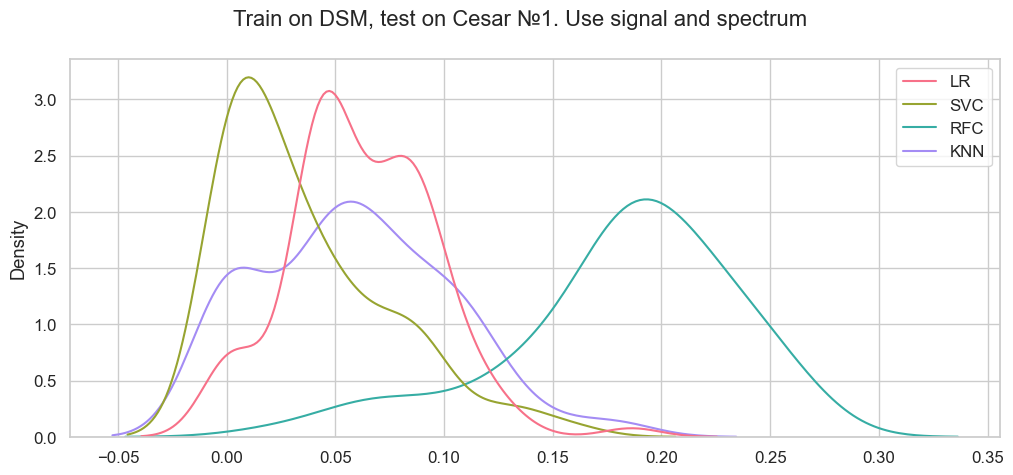

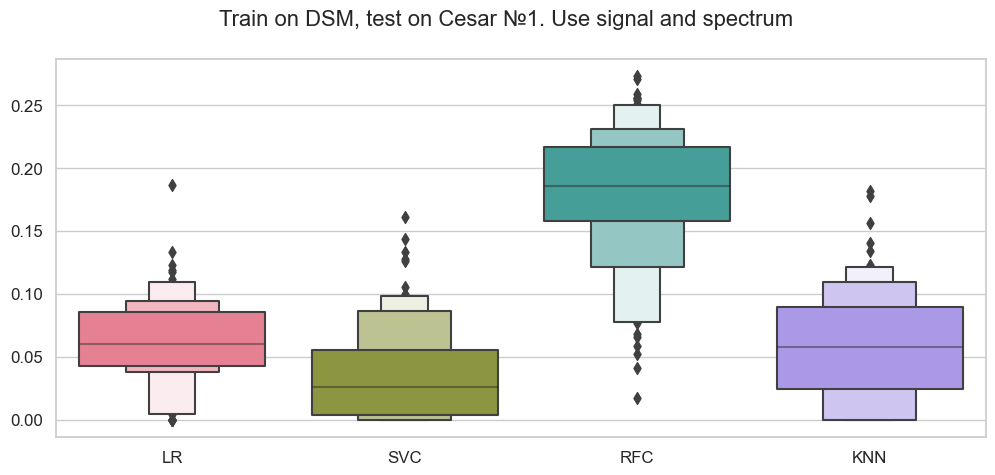

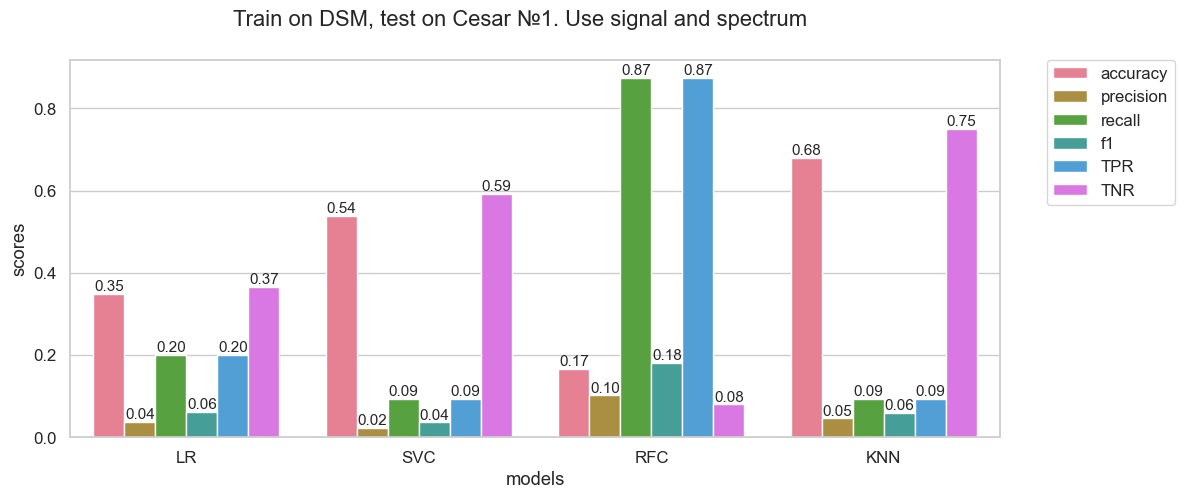

In [4]:
from source.postprocessing.plotter import dist_plot, bar_plot


plot_info = '. Use signal and spectrum'
filename_info = 'GS_noscale'
dist_plot(results=GS_results_objects, models=names, plot_type='kdeplot', metric='f1', title=f'Train on DSM, test on Cesar №1{plot_info}', to_png=True, filename=f'kde_DSM_C1_{filename_info}.png', filepath=os.path.join(root, images_path))

dist_plot(results=GS_results_objects, models=names, plot_type='boxenplot', metric='f1', title=f'Train on DSM, test on Cesar №1{plot_info}', to_png=True, filename=f'box_DSM_C1_{filename_info}.png', filepath=os.path.join(root, images_path))

bar_plot(results=GS_results_objects, models=names, metrics=score_names.keys(), title=f'Train on DSM, test on Cesar №1{plot_info}', plot_vals=True, to_png=True, filename=f'bar_DSM_C1_{filename_info}.png', filepath=os.path.join(root, images_path))

In [5]:
from source.postprocessing.mljson import deserialize_results
from source.datamodels.iterators import Metrics


names = ['LR', 'SVC', 'RFC', 'KNN']
score_names = Metrics.get_scorers_dict()

GS_results_objects_ = deserialize_results(BootstrapDatasetsComparisonResults, filenames=[f"{model}_C1_DSM_GS_noscale.json" for model in names], filepath=os.path.join(root, bootstrap_jsons_path, 'DatasetsCompare'))

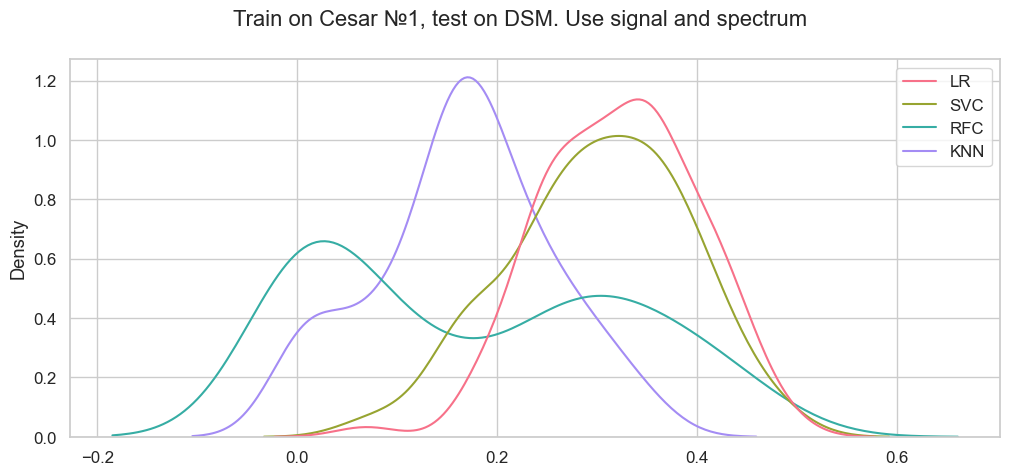

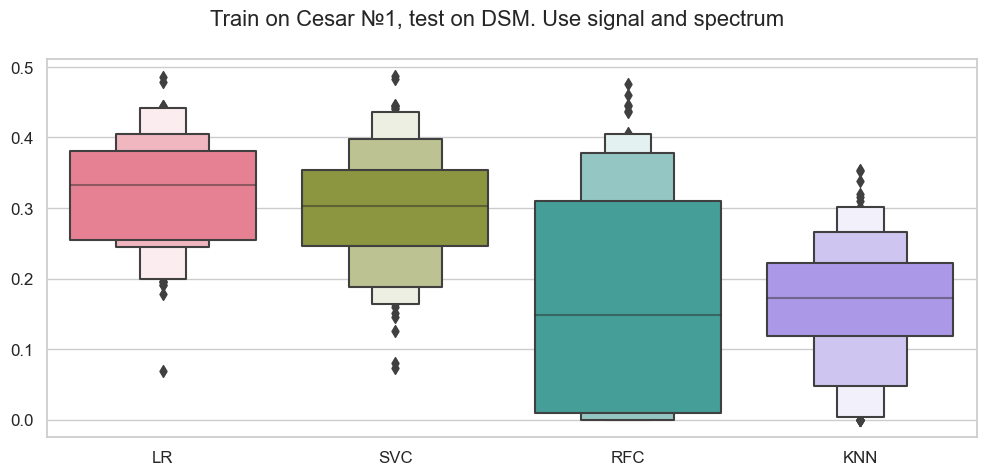

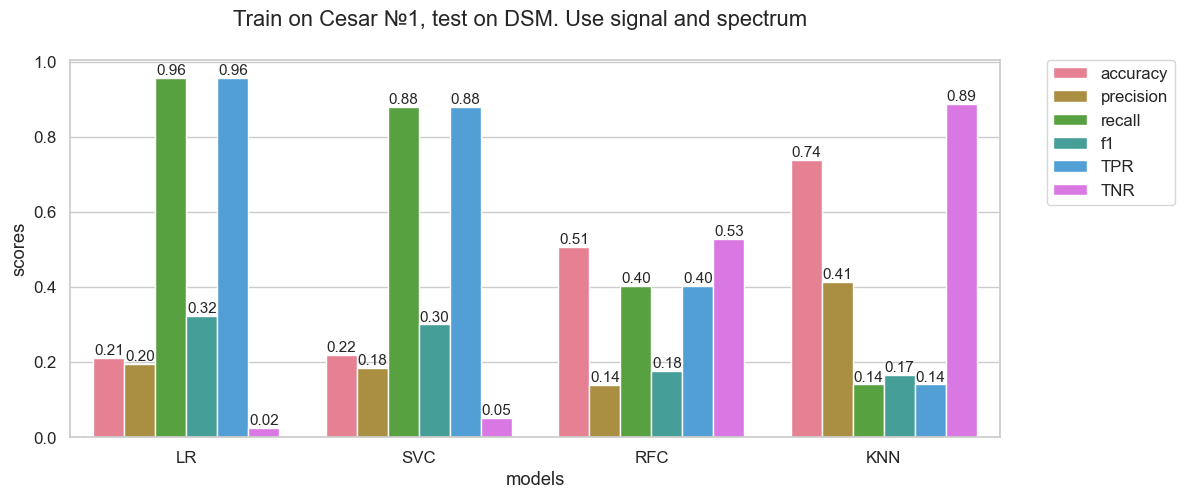

In [6]:
from source.postprocessing.plotter import dist_plot, bar_plot


plot_info = '. Use signal and spectrum'
filename_info = 'GS_noscale'
dist_plot(results=GS_results_objects_, models=names, plot_type='kdeplot', metric='f1', title=f'Train on Cesar №1, test on DSM{plot_info}', to_png=True, filename=f'kde_C1_DSM_{filename_info}.png', filepath=os.path.join(root, images_path))

dist_plot(results=GS_results_objects_, models=names, plot_type='boxenplot', metric='f1', title=f'Train on Cesar №1, test on DSM{plot_info}', to_png=True, filename=f'box_C1_DSM_{filename_info}.png', filepath=os.path.join(root, images_path))

bar_plot(results=GS_results_objects_, models=names, metrics=score_names.keys(), title=f'Train on Cesar №1, test on DSM{plot_info}', plot_vals=True, to_png=True, filename=f'bar_C1_DSM_{filename_info}.png', filepath=os.path.join(root, images_path))

# 5 Create table with results
Since we have conducted 4 types of training, we create 4 separate tables with results of our experiments.
Experiments:
1. Train on our dataset (also named as DSM), test on Cesar Ricardo №1 dataset
2. Train on DSM dataset, test on Cesar Ricardo №2 dataset
3. Train on  Cesar Ricardo №1, test on DSM dataset
4. Train on  Cesar Ricardo №2, test on DSM dataset

In [4]:
from source.datamodels.datamodels import BootstrapDatasetsComparisonResults
from source.postprocessing.mlcsv import generate_csv_from_results, create_readable_xlsx
from source.postprocessing.mljson import deserialize_results

In [14]:
whole_results = deserialize_results(BootstrapDatasetsComparisonResults, filepath=os.path.join(root, bootstrap_jsons_path, 'DatasetsCompare'))

print(f"results count: {len(whole_results)}")
DSM_C1 = []
DSM_C2 = []
C1_DSM = []
C2_DSM = []


for res in whole_results:
    if res.train_dataset_name == 'our':
        res.train_dataset_name = 'DSM'

    if res.test_dataset_name == 'our':
        res.test_dataset_name = 'DSM'

for res in whole_results:
    if res.train_dataset_name == 'Cesar1':
        C1_DSM.append(res)
    elif res.train_dataset_name == 'Cesar_2' or res.train_dataset_name == 'Cesar2':
        C2_DSM.append(res)

    elif res.test_dataset_name == 'Cesar1':
        DSM_C1.append(res)
    elif res.test_dataset_name == 'Cesar_2':
        DSM_C2.append(res)

print(f"results with train on DSM and test on Cesar №1: {len(DSM_C1)}")
print(f"results with train on DSM and test on Cesar №2: {len(DSM_C2)}")
print(f"results with train on Cesar №1 and test on DSM: {len(C1_DSM)}")
print(f"results with train on Cesar №2 and test on DSM: {len(C2_DSM)}")

results count: 64
results with train on DSM and test on Cesar №1: 16
results with train on DSM and test on Cesar №2: 16
results with train on Cesar №1 and test on DSM: 16
results with train on Cesar №2 and test on DSM: 16


In [13]:
generate_csv_from_results(DSM_C1, "DSM_C1.csv", results_type=BootstrapDatasetsComparisonResults, csv_path=os.path.join(root, tables_path))
create_readable_xlsx("DSM-to-Cesar №1 comparison results.xlsx", "DSM_C1.csv", csv_path=os.path.join(root, tables_path), xlsx_path=os.path.join(root, tables_path, 'public'))

generate_csv_from_results(DSM_C2, "DSM_C2.csv", results_type=BootstrapDatasetsComparisonResults, csv_path=os.path.join(root, tables_path))
create_readable_xlsx("DSM-to-Cesar №2 comparison results.xlsx", "DSM_C2.csv", csv_path=os.path.join(root, tables_path), xlsx_path=os.path.join(root, tables_path, 'public'))

generate_csv_from_results(C1_DSM, "C1_DSM.csv", results_type=BootstrapDatasetsComparisonResults, csv_path=os.path.join(root, tables_path))
create_readable_xlsx("Cesar №1-to-DSM comparison results.xlsx", "C1_DSM.csv", csv_path=os.path.join(root, tables_path), xlsx_path=os.path.join(root, tables_path, 'public'))

generate_csv_from_results(C2_DSM, "C2_DSM.csv", results_type=BootstrapDatasetsComparisonResults, csv_path=os.path.join(root, tables_path))
create_readable_xlsx("Cesar №2-to-DSM comparison results.xlsx", "C2_DSM.csv", csv_path=os.path.join(root, tables_path), xlsx_path=os.path.join(root, tables_path, 'public'))